[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


100%|██████████| 10000/10000 [05:34<00:00, 29.90it/s]   | 1/10000 [00:00<33:35,  4.96it/s]


0.71604937315
0.627240121365


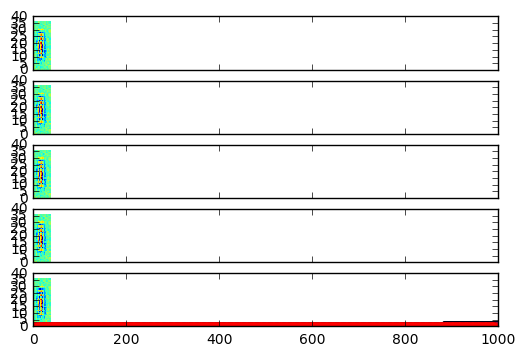

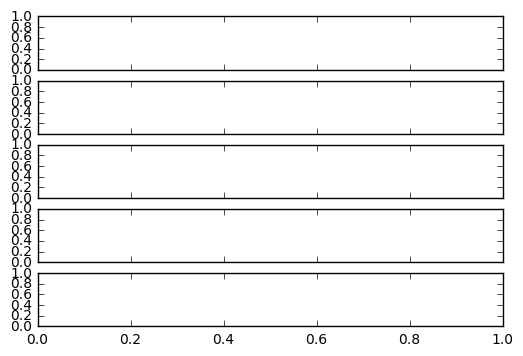

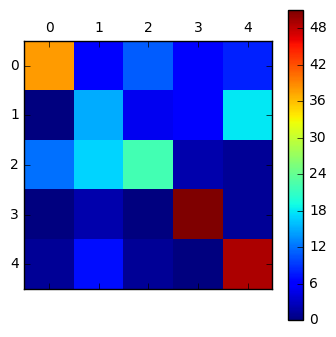

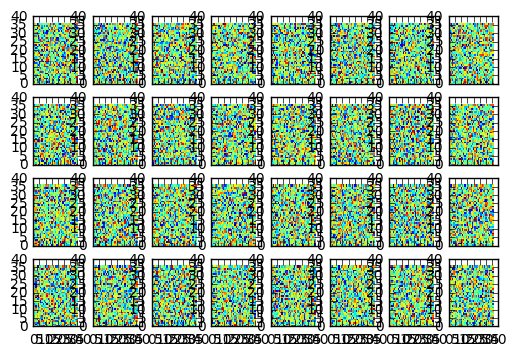

In [5]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']
# Look at some data
print(train[0])
print(labels[0])

plt.ion()
f, plts = plt.subplots(5, sharex = True)
c = 91

for i in range(5):
    plts[i].pcolor(train[c + i * 558], cmap = plt.cm.gray_r)
    

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])


W = tf.Variable(tf.truncated_normal([1296, 5],
                                        stddev=1./math.sqrt(1296)))
b = tf.Variable(tf.constant(0.1,shape=[5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(x,W) + b)

# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### End model specification, begin training code

epochs = 10000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs)):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

#print accuracy
print(train_acc[-1])
print(test_acc[-1])
    
# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

#Look at the subplots if the weights for each font
f. plts = plt.subplots(5, sharex = True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,1].reshape([36,36]))
    

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()


# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))